<a href="https://colab.research.google.com/github/ebrahimpichka/DeepRL-trade/blob/main/DeepRL_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading Using Deep Reinforcdment Learning

### Table of Contents

- [Introduction](#scrollTo=9SNR5Z82unXd)

- [Import Dependencies](#scrollTo=012Sf4GHumaL)

- [Data & Preprocessing](#scrollTo=fAq9RY7dtwTe)

- [Custom Trading Environment Setting](#scrollTo=z-g6RJHLpuKh)

- [Utility Functions](#scrollTo=jWElTzIctZ3E)

- [PPO Agent](#scrollTo=rz1CA85UkXPI)

  - [Agent setting](#scrollTo=bKxYFvx8nALx)

  - [Training](#scrollTo=VXm3OnAlnF51)

  - [Results and Validation](#scrollTo=3D6ypjL-nh8J)

- [DQN Agent](#scrollTo=F1SfonB9kXPR)

  - [Agent Setting](#scrollTo=hIqzHqzPn2Lv)

  - [Training](#scrollTo=6tBBq8TQn7JZ)

  - [Results and Validation](#scrollTo=SukTkoX8oExx)

- [Visualization](#scrollTo=V48fsZn7jv9Q)



## Introduction

In quantitative finance, stock trading is essentially a dynamic decision problem, that is, deciding where, at what price, and how much to trade in a highly stochastic, dynamic, and complex stock market. With recent advances in deep reinforcement learning (DRL) methods, sequential dynamic decision problems can be modeled and solved with a human-like approach.

<br>

In this poject, we examine the potential and performance of deep reinforcement learning to optimize stock trading strategies and thus maximize investment returns. Google stock is selected as our trading stock and the daily opening and closing price along with trading volume and several technical indicators are used as a training environment and trading market.

<br>

We present two trading agents based on deep reinforcement learning, one using Proximal Policy Otimization algorithm and the other based on Deep Q-Learing, to autonomously make trading decisions and generate returns in dynamic financial markets. The performance of these intelligent agents is compared with the performance of the buy and hold strategy. And at the end, it is shown that the proposed deep reinforcement learning approach performs better than the buy and hold benchmark in terms of risk assessment criteria and portfolio return.

---


**References:**
* Human-level control through deep reinforcement learning (Deep Q-Learning) : [paper](https://www.nature.com/articles/nature14236)
* Proximal Policy Optimization) : [paper](https://arxiv.org/abs/1707.06347), [blog](https://openai.com/blog/openai-baselines-ppo/), [spinning-up](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

## Import Dependencies

In [ ]:
%%capture
!pip install talib-binary
!pip install gym_anytrading
!pip install quantstats
!pip install stable_baselines3
!pip install pyfolio
!pip install --upgrade gym==0.25.2
!pip install stable_baselines

In [ ]:
import os
import math
import talib
import numpy as np
import pandas as pd
from scipy.stats import t
from pandas_datareader import data as web
import pandas_datareader as pdr
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from gym.utils import seeding
import gym
from gym import spaces
import logging
import datetime
import pyfolio.timeseries as ts
import scipy.stats as st

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
# from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs

from stable_baselines3 import A2C, DDPG, DQN, PPO, TD3, SAC
# from stable_baselines import TRPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# import torch
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy

from sklearn.preprocessing import scale


DECIMAL_SIGNS = 5
rnd = lambda x: round(x, DECIMAL_SIGNS)

#===========

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

In [ ]:
#============
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.info('%s logger started.', __name__)
#============

INFO:__main__:__main__ logger started.


----

## Data & Preprocessing

creating DataSource class to handle fetching data and calculating technical indicators.

In [ ]:
class DataSource(object):
    def __init__(self, data_path, start_date, end_date,
                    time_frame, tickers, window_size,
                    # train_mode=True,
                    # episode_duration=480,
                    # train_split=0.8, normalize=True
                    ):

        self.tickers = tickers

        if end_date == None:
            end_date = datetime.datetime.now()
        if start_date == None:
            start_date = end_date - relativedelta(years=2)

        self.data = pd.DataFrame()
        for ticker in self.tickers:
            csv_name = os.path.join(
                            data_path,
                            ticker+start_date.strftime('_from_%Y%m%d')+end_date.strftime('_to_%Y%m%d')+".csv"
                            )
            ticker_data = self._load_data(
                                csv_name=csv_name, time_frame=time_frame,
                                start_date=start_date, end_date=end_date, ticker=ticker
                                )
            self.data = pd.concat(
                [self.data, ticker_data],
                # join='inner'
                )

        self.date_time = self.data.index
        self.count = self.data.shape[0]
        self.window_size = window_size
        self.states = self.data.values


    @staticmethod
    def seed(seed):
        np.random.seed(seed)

    
    def _load_data(self, csv_name, time_frame, start_date, end_date,  ticker):
        log.info('loading data for {}...'.format(ticker))

        if os.path.exists(csv_name):
            df = pd.read_csv(csv_name)
        else:
            with open("./tiingo_api_key.txt") as file:
                key = file.readline()
            
            # df = web.DataReader(ticker, time_frame,
            #     start=start_date,
            #     end=end_date,
            #     api_key=key
            #     ).dropna()
            df = pdr.get_data_tiingo(ticker,
                start=start_date,
                end=end_date,
                api_key=key
                ).dropna()
            
            df.columns = [col.lower() for col in df.columns]

            # print(df.columns)

            df['ret_5'] = df.adjopen.pct_change(5)
            df['ret_10'] = df.adjopen.pct_change(10)
            df['ret_21'] = df.adjopen.pct_change(21)
            df['rsi'] = talib.STOCHRSI(df.adjopen)[1]
            df['macd'] = talib.MACD(df.adjopen)[1]
            df['atr'] = talib.ATR(df.adjhigh, df.adjlow, df.adjopen)
            df = df.replace((np.inf, -np.inf), np.nan).drop(['high', 'low','close','open','adjhigh', 'adjlow','divcash','splitfactor'], axis=1).dropna()
            df.columns = [col+'_'+ticker for col in df.columns]
            df.to_csv(csv_name,index_label="date_time")
            

        log.info('got data for {}...'.format(ticker))
        return df

    def get_start_end_index(self,a,b):
        
        start_index = np.random.randint(a, b-20)
        end_index = np.random.randint(start_index+10, b)
    
        return start_index, end_index


In [ ]:
config = {
            "data": {
                "time_frame": "tiingo",
                "data_path": os.path.join(os.getcwd(), "data"),
                "tickers": ["GOOG","IBM"],
                "episode_duration": 480
                },
            "seed": 42,
            "model": {
                "window_size": 10,
                "initial_cash": 1_000_000,
                "commission_rate":0,
                "start_date": datetime.datetime(2014,1,1),
                "end_date": datetime.datetime(2022,8,1),
                "stat_save_folder": None,
                "agent_save_folder": None
                 },
            "ddpg": {
                "buffer_size": 100000,
                "batch_size": 64,
                "gamma": 0.99,
                "tau": 0.001,
                "learning_rate_actor": 0.0001,
                "learning_rate_critic": 0.001,
                "explore": 1000000.,
                "weight_decay": 0,
                "eps":0.1,
                "eps_decay":0.001
                }
        }

In [ ]:
data_config = config['data']
seed = config.get("seed", 42)

stat_save_path = os.path.join(os.getcwd(),"saved_stats")
if not os.path.exists(stat_save_path):
    os.mkdir(stat_save_path)
stat_save_folder  = os.path.join(stat_save_path, "ddpg_" + datetime.datetime.now().strftime('%Y%m%d'))
if not os.path.exists(stat_save_folder):
    os.mkdir(stat_save_folder)

agent_save_path = os.path.join(os.getcwd(),"saved_agents")
if not os.path.exists(agent_save_path):
    os.mkdir(agent_save_path)
agent_save_folder  = os.path.join(agent_save_path, "ddpg_" + datetime.datetime.now().strftime('%Y%m%d'))
if not os.path.exists(agent_save_folder):
    os.mkdir(agent_save_folder)

np.random.seed(seed)
window_size = config["model"]["window_size"]
data_path = config["data"]["data_path"] 
tickers = config["data"]["tickers"]
time_frame = config["data"]["time_frame"]
start_date, end_date = config["model"]["start_date"] , config["model"]["end_date"] 

In [ ]:
data_path

'/content/data'

In [ ]:
data_source_goog = DataSource(
    data_path=data_path,
    start_date=start_date,
    end_date=end_date,
    time_frame=time_frame,
    tickers=["GOOG"],
    window_size=window_size,
)


INFO:__main__:loading data for GOOG...
INFO:__main__:got data for GOOG...
INFO:__main__:loading data for SPY...
INFO:__main__:got data for SPY...


In [ ]:
goog = data_source_goog.data

In [ ]:
def preprocess(df, ticker):
    df.set_index("date_time", inplace=True)
    # df_train = df.iloc[:int(0.8*len(df)),[1,2,3,4,5,7,8,9]].copy()
    # df_test = df.iloc[int(0.8*len(df)):,[1,2,3,4,5,7,8,9]].copy()
    df_train = df.iloc[:int(0.8*len(df)),:].copy()
    df_test = df.iloc[int(0.8*len(df)):,:].copy()

    sig_train = df_train.rolling(30).std()
    sig_test = df_test.rolling(30).std()

    mu_train = df_train.rolling(30).mean()
    mu_test = df_test.rolling(30).mean()

    eps = np.finfo(np.float32).eps

    df_train_norm = ((df_train - mu_train.shift())/(sig_train + eps)).dropna()
    df_test_norm = ((df_test - mu_test.shift())/(sig_test + eps)).dropna()

    df_train_norm.columns = [col+"_norm" for col in df_train_norm.columns]
    df_test_norm.columns = [col+"_norm" for col in df_test_norm.columns]

    df_train_norm["adjclose_"+ticker] = df_train["adjclose_"+ticker][30:].values
    df_train_norm["adjopen_"+ticker] = df_train["adjopen_"+ticker][30:].values
    df_test_norm["adjclose_"+ticker] = df_test["adjclose_"+ticker][30:].values
    df_test_norm["adjopen_"+ticker] = df_test["adjopen_"+ticker][30:].values

    return(df_train, df_test, df_train_norm, df_test_norm)


In [ ]:
df_train, df_test, df_train_norm, df_test_norm = preprocess(goog.copy(), "GOOG")

In [ ]:
df_train.head()

,adjclose_GOOG,adjopen_GOOG,adjvolume_GOOG,ret_5_GOOG,ret_10_GOOG,rsi_GOOG,macd_GOOG,atr_GOOG
date_time,,,,,,,,
2014-05-14 00:00:00+00:00,26.3325,26.6500,23770000,0.033366,0.010235,100.000000,-0.608101,0.800339
2014-05-15 00:00:00+00:00,25.9990,26.2850,33994000,0.033906,-0.002675,90.697465,-0.569027,0.798815
2014-05-16 00:00:00+00:00,26.0315,26.0695,29624000,0.020832,-0.023175,57.364132,-0.534635,0.778399
2014-05-19 00:00:00+00:00,26.4430,25.9850,25486000,-0.007278,-0.009756,24.030798,-0.505111,0.766360
2014-05-20 00:00:00+00:00,26.4885,26.4870,35598000,-0.002166,0.008587,31.528101,-0.471024,0.770656


## Custom Trading Environment Setting

An environment with the OpenAI gym interface to simulate market movement and reward generation.

The agent moves to the beginning of the next trading day by taking action at each step, and its assets' value change over time.

In [ ]:
class MyTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size, frame_bound, init_cash=100_000, symbol="", IS_DQN=False):
        assert df.ndim == 2

        self.seed()
        self.df = df
        
        self.symbol = symbol
        self.IS_DQN = IS_DQN
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.dates = df.index
        self.open_prices, self.close_prices, self.signal_features = self._process_data()
        self.shape = (window_size *  self.signal_features.shape[1],)
        
        # defining Action and State spaces
        self.action_space = spaces.Discrete(n=3)
        # self.action_space = spaces.Box(low=-1,high=1,shape=(1,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)


        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.open_prices) - 1
        # self._start_tick , self._end_tick = get_start_end_index(self.frame_bound[0],self.frame_bound[1])
        self.starting_price = self.open_prices[self._start_tick]
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self.init_cash = init_cash
        self._cash = init_cash
        self._position_value = 0
        self._total_assets = self._cash + self._position_value
        self._init_total_assets = self._total_assets
        self._last_trade = 0
        self._position_history = None
        self._actions_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, rand_trail=False):
        self._done = False
        if rand_trail:
            self._start_tick , _ = get_start_end_index(self.frame_bound[0], self.frame_bound[1])
        else:
            self._start_tick = self.frame_bound[0]
        self._end_tick = self.frame_bound[1] - 1 
        self._current_tick = self._start_tick
        self.starting_price = self.open_prices[self._start_tick]
        self.curr_open_price = self.open_prices[self._start_tick]
        self._last_trade_tick = self._current_tick - 1
        self._cash = self.init_cash
        self._position_value = 0
        self._total_assets = self._cash + self._position_value
        self._init_total_assets = self._total_assets
        self._last_trade = 0
        self._position_history = (self.window_size * [0]) + [self._position_value]
        self._trade_history = (self.window_size * [0]) + [self._last_trade]
        self._actions_history = ((1+self.window_size) * [0]) 
        self._total_reward = 0.
        self._total_profit = 0.  # unit
        self._total_pct_profit = 0
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        
        self._done = False
        self._current_tick += 1
        self.curr_open_price = self.open_prices[self._current_tick]

        # if self.IS_DQN:
        #     action = action-1
        action = action-1
        if self._current_tick == self._end_tick:
            self._done = True
        if -0.01<action<0.01:
            action = np.zeros(1)
        action = action.item()
        last_day_total_assets = self._total_assets
        step_reward = self._calculate_reward(action)
        self._actions_history.append(action)
        self._total_reward += step_reward
        self._total_profit = self._total_assets - self.init_cash
        self._total_pct_profit = self._total_profit/self.init_cash

        # self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            date = self.dates[self._current_tick],
            total_reward = rnd(self._total_reward),
            total_profit = rnd(self._total_profit),
            total_profit_percentage = rnd(self._total_pct_profit),
            buy_and_hold = rnd((self.curr_open_price/self.starting_price)-1),
            daily_price_return =rnd((self.curr_open_price/self.open_prices[self._current_tick-1])-1),
            daily_return = rnd((self._total_assets/last_day_total_assets)-1),
            total_assets = rnd(self._total_assets),
             
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        sig = self.signal_features[(self._current_tick-self.window_size):self._current_tick]
        # obs = np.hstack([np.array(self._cash/self.init_cash), np.array(self._position_value/self.init_cash),
        #                     sig.reshape(-1)])
        return(sig.reshape(-1))


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position > 0:
                color = 'red'
            elif position < 0:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.open_prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(self._start_tick, self._end_tick)
        plt.plot(
            pd.to_datetime(self.dates),
            self.open_prices,
            label=f"Open Price - {self.symbol}"
            )

        short_ticks = []
        short_ticks_dates = []
        long_ticks = []
        long_ticks_dates = []
        for i, tick in enumerate(window_ticks):
            if self._trade_history[i] < 0:
                short_ticks.append(tick)
                short_ticks_dates.append(
                    self.dates[tick]
                )
            elif self._trade_history[i] > 0:
                long_ticks.append(tick)
                long_ticks_dates.append(
                    self.dates[tick]
                )

        plt.plot(
            pd.to_datetime(short_ticks_dates),
            self.open_prices[short_ticks],
            'rv',
            markersize=6,
            label="Sell"
            )
        plt.plot(
            pd.to_datetime(long_ticks_dates),
            self.open_prices[long_ticks],
            'g^',
            markersize=6,
            label="Buy"
            )

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        close_prices = self.df.loc[:, 'adjclose_'+self.symbol].to_numpy()
        open_prices = self.df.loc[:, 'adjopen_'+self.symbol].to_numpy()

        open_prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        # close_prices = close_prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]
        # open_prices = open_prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        # diff = np.insert(np.diff(prices), 0, 0)
        # signal_features = np.column_stack((prices, diff))
        features = ['adjopen_'+self.symbol, 'adjvolume_'+self.symbol,
                    'ret_5_'+self.symbol, 'ret_10_'+self.symbol,
                    'ret_21_'+self.symbol, 'rsi_'+self.symbol,
                    'macd_'+self.symbol,'atr_'+self.symbol]

        signal_features = self.df[features].values

        return(open_prices, close_prices, signal_features)


    def _calculate_reward(self, action):

        trade = True
        step_reward = 0
        
        current_price = self.open_prices[self._current_tick]
        last_day_price = self.open_prices[self._current_tick-1]
        pct_change = (current_price)/last_day_price

        before_position_value = self._position_value
        before_total_assets = self._total_assets
        self._position_value *= pct_change
        self._total_assets = self._cash + self._position_value

        if trade:
            total_assets = self._total_assets
            new_position_value = action * total_assets
            position_value_diff = new_position_value - self._position_value

            num_assets_to_trade = position_value_diff // current_price

            actual_position_value_diff = num_assets_to_trade*current_price
            actual_new_position_value = actual_position_value_diff + self._position_value

            ## TODO: try different reward functions.
            ## TODO: add rewards for commission, etc.

            self._position_value = actual_new_position_value
            self._cash = total_assets - actual_new_position_value
            self._total_assets = self._cash + self._position_value

            self._last_trade = actual_position_value_diff
            self._trade_history.append(num_assets_to_trade)
            self._position_history.append(actual_new_position_value)
            self._last_trade_tick = self._current_tick
        else:
            
            self._trade_history.append(0)
            self._position_history.append(self._position_value)

        # step_reward = 0
        # bnh = ((current_price/self.starting_price)-1)
        # step_reward += (((self._total_assets - self.init_cash))/self.init_cash)-bnh
        # step_reward = (self._total_assets - before_total_assets)
        step_reward = ((self._total_assets - before_total_assets)/before_total_assets)

        return step_reward

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [ ]:
print((df_ibm_train.index[0], df_ibm_train.index[-1]),"\n",
      (df_ibm_test.index[0], df_ibm_test.index[-1]))

('2014-02-20 00:00:00+00:00', '2020-11-18 00:00:00+00:00') 
 ('2020-11-19 00:00:00+00:00', '2022-08-01 00:00:00+00:00')


In [ ]:
env_maker = lambda: MyTradingEnv(
    df=df_train,
    window_size=window_size,
    frame_bound=(window_size,len(df_train)),
    symbol="GOOG"
    )
# env = DummyVecEnv([env_maker])

env = MyTradingEnv(
    df=df_train,
    window_size=window_size,
    frame_bound=(window_size,len(df_train)),
    symbol="GOOG"
    )

test_env = MyTradingEnv(
    df=df_test,
    window_size=window_size,
    frame_bound=(window_size, len(df_test)),
    symbol="GOOG"
    )

# env = MyTradingEnv(df=df_train_norm, window_size=window_size, frame_bound=(window_size, len(df_train_norm)))
# test_env = MyTradingEnv(df=df_test_norm, window_size=window_size, frame_bound=(window_size, len(df_test_norm)))

## Utility Functions

In [ ]:
def get_start_end_index(a,b):
        
    start_index = np.random.randint(a, b-20)
    end_index = np.random.randint(start_index+10, b)

    return start_index, end_index

In [ ]:
def test_model(model, test_env, rounds=500):
    '''
    Calculates Performance statistics on the test environment over multiple
    rounds of interactionwith the test environment.

    calculated statistics are:
        point estimation (mean)
        %95 confidence interval bound
        %99 confidence interval bound
        3-standard deviation (3sigma) interval
        3-standard deviation (3sigma) interval
        best 5 percentile
        worst 5 percentile
        best 20 percentile
        best 20 percentile

    metrics are:
        total_reward
        total_profit
        total_profit_percentage
        buy_and_hold
        daily_price_return
        daily_return
        total_assets
        performance metrics: (
            Annual return
            Cumulative returns
            Annual volatility
            Sharpe ratio
            Calmar ratio
            Stability
            Max drawdown
            Omega ratio
            Sortino ratio
            Skew
            Kurtosis
            Tail ratio
            Daily value at risk
            )

    Parameters
    ----------
        - model: RL Agent instance (`Agent` class from stablebaseline3 )
        - test_env: Trading environment to test on. (`Mytradingenv` class with OpenAI gym interface)
        - rounds: number of rounds to fully interact with test environment.
            statistics are calculated over this number of runs. (`int`)
    
    Returns
    ----------
        - mean_res: dictionary containing performance statistics of the agent on
            the test_env.
    '''
    res = dict(
        date = [],
        total_reward = [],
        total_profit = [],
        total_profit_percentage = [],
        buy_and_hold = [],
        daily_price_return = [],
        daily_return = [],
        total_assets = [],
        perf_stat = pd.DataFrame(),
        bnh_perf_stat = pd.DataFrame()
        )
    
    for itr in tqdm(range(rounds)):
        observation = test_env.reset(False)

        while True:
            action, _states = model.predict(observation)
            observation, reward, done, info = test_env.step(action)

            # env.render()
            if done:
                # print("info:", info)
                break

        for key in test_env.history.keys():
            res[key].append(test_env.history[key])

        res["perf_stat"] = pd.concat(
            [
            res["perf_stat"],
            ts.perf_stats(np.array(test_env.history['daily_return']))
            ],
            axis=1)

    for key , val in res.items():
        if key not in ['date', 'perf_stat']:
            res[key] = np.array(val)

    mean_res = {}
    for k, v in res.items():
        if k == 'date':
            mean_res[k] = v[0]
        elif k == 'perf_stat':

            m = v.mean(1)
            s = v.std(1)
            dof = rounds-1

            se = st.sem(v.values, axis=1)
            # h = se * st.t.ppf((1 + confidence) / 2., dof)
            # lower95, upper95 = (m-s*(t_crit95/np.sqrt(rounds)), m+s*(t_crit95/np.sqrt(rounds)))
            # lower99, upper99 = (m-s*(t_crit99/np.sqrt(rounds)), m+s*(t_crit99/np.sqrt(rounds)))
            # stats = pd.concat([pd.Series(m),pd.Series(se)],axis=1)
            
            lower95, upper95 = st.t.interval(alpha=0.95, df=dof, loc=m, scale=se)
            lower99, upper99 = st.t.interval(alpha=0.99, df=dof, loc=m, scale=se)

            lower95 = pd.Series(lower95)
            upper95 = pd.Series(upper95)
            lower99 = pd.Series(lower99)
            upper99 = pd.Series(upper99)
            
            lower95.index = v.index
            upper95.index = v.index
            lower99.index = v.index
            upper99.index = v.index

            lower_3s = m - 1.5*s
            upper_3s = m + 1.5*s

            # ===============================
            
            best5pct = np.quantile(v.values, 0.95, axis=1)
            worst5pct = np.quantile(v.values, 0.05, axis=1)
            best20 = np.quantile(v.values, 0.8, axis=1)
            worst20 = np.quantile(v.values, 0.2, axis=1)

            best5pct = pd.Series(best5pct)
            worst5pct = pd.Series(worst5pct)
            best20 = pd.Series(best20)
            worst20 = pd.Series(worst20)

            best5pct.index = v.index
            worst5pct.index = v.index
            best20.index = v.index
            worst20.index = v.index

            # ===============================

            mean_res[k] = pd.concat([m ,
                                    lower95, upper95,
                                    lower99, upper99,
                                    lower_3s, upper_3s,
                                    best5pct, worst5pct,
                                    best20, worst20
                                    ], axis=1
                                    )
            
            mean_res[k].columns = ["point_est (mean)",
                                   "%95 conf. lower bound", "%95 conf. upper bound",
                                   "%99 conf. lower bound", "%99 conf. upper bound",
                                   "3sigma lower", "3sigma upper",
                                   "best_5_pctile", "worst_5_pctile",
                                   "best_20_pctile", "best_20_pctile"
                                   ]
        
        elif k=="bnh_perf_stat":
            mean_res[k] = ts.perf_stats(
                test_env.df["adjopen_"+test_env.symbol][test_env.frame_bound[0]:test_env.frame_bound[1]].pct_change().fillna(0).values
                )
        elif k in ["buy_and_hold", "daily_price_return"]:
            mean_res[k] = v.mean(0)
        else:
            mean_res[k+"_point"] = v.mean(0)
            m = v.mean(0)
            s = v.std(0)
            dof = rounds-1

            # t_crit95 = np.abs(t.ppf((1-0.95)/2,dof))
            # t_crit99 = np.abs(t.ppf((1-0.99)/2,dof))

            # lower95, upper95 = (m-s*(t_crit95/np.sqrt(rounds)), m+s*(t_crit95/np.sqrt(rounds)))
            # lower99, upper99 = (m-s*(t_crit99/np.sqrt(rounds)), m+s*(t_crit99/np.sqrt(rounds)))
            se = st.sem(v, axis=0)
            lower95, upper95 = st.t.interval(alpha=0.95, df=dof, loc=m, scale=se)
            lower99, upper99 = st.t.interval(alpha=0.99, df=dof, loc=m, scale=se)

            mean_res[k+"_lower95"] = lower95
            mean_res[k+"_upper95"] = upper95

            mean_res[k+"_lower99"] = lower99
            mean_res[k+"_upper99"] = upper99

            mean_res[k+"_min"] = v.min(0)
            mean_res[k+"_max"] = v.max(0)

            mean_res[k+"_best5pctile"] = np.quantile(v, 0.95, axis=0)
            mean_res[k+"_worst5pctile"] = np.quantile(v, 0.05, axis=0)

            mean_res[k+"_best20pctile"] = np.quantile(v, 0.8, axis=0)
            mean_res[k+"_worst20"] = np.quantile(v, 0.2, axis=0)

            mean_res[k+"_lower3S"] = m - 1.5*s
            mean_res[k+"_upper3S"] = m + 1.5*s
     
    return(mean_res)


In [ ]:
def plot_test_result(
        result_dict,
        model_name,
        symbol,
        split="Test",
        plot_95_conf=True,
        plot_99_conf=False,
        plot_6s=True,
        plot_minmax=False,
        plot_bestworst20=False,
        plot_bestworst5=False,
        ):
    '''
    Plots the performance metrics and statistics from the Agent test results
    '''
    plt.style.use("seaborn")
    plt.figure(figsize=(16,10))
    plt.title(f"{model_name} {split} Performance - {symbol}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"{model_name} {split} Performance - {symbol}")
    # plt.plot(x,np.array(test_env.history['buy_and_hold'])*test_env.init_cash)
    plt.plot(pd.to_datetime(result_dict['date']), result_dict['buy_and_hold'], label="Buy and Hold")
    plt.plot(pd.to_datetime(result_dict['date']), result_dict['total_profit_percentage_point'],label=model_name,color="r")

    if plot_95_conf:
        plt.fill_between(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_percentage_upper95'],
            result_dict['total_profit_percentage_lower95'],
            label="95% Conf. Int.",
            alpha=0.8
            )

    if plot_99_conf:
        plt.fill_between(
            range(len(result_dict['date'])),
            result_dict['total_profit_percentage_upper99'],
            result_dict['total_profit_percentage_lower99'],
            label="99% Conf. Int.",
            alpha=0.6
            )

    if plot_6s:
        plt.fill_between(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_percentage_upper3S'],
            result_dict['total_profit_percentage_lower3S'],
            label="3 Sigma",
            alpha=0.65
            )
    
    if plot_minmax:
        plt.fill_between(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_percentage_max'],
            result_dict['total_profit_percentage_min'],
            label="Min/Max",
            alpha=0.3
            )
    
    if plot_bestworst20:
        plt.plot(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_best20pctile'],
            label="Best 20th percentile",
            alpha=0.5
            )
        plt.plot(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_worst20pctile'],
            label="Worst 20th percentile",
            alpha=0.5
            )
        # plt.fill_between(
        #     pd.to_datetime(result_dict['date']),
        #     result_dict['total_profit_best20pctile'],
        #     result_dict['total_profit_worst20pctile'],
        #     label="Best/Worst 20 percentile",
        #     alpha=0.5
        #     )

    if plot_bestworst5:
        plt.plot(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_best5pctile'],
            label="Best 5th percentile",
            alpha=0.5
            )
        plt.plot(
            pd.to_datetime(result_dict['date']),
            result_dict['total_profit_worst5pctile'],
            label="Worst 5th percentile",
            alpha=0.5
            )
        # plt.fill_between(
        #     pd.to_datetime(result_dict['date']),
        #     result_dict['total_profit_best5pctile'],
        #     result_dict['total_profit_worst5pctile'],
        #     label="Best/Worst 5 percentile",
        #     alpha=0.4
        #     )
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

-------
## PPO Agent

### Agent setting

In [ ]:

class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.07),
            nn.Linear(256, last_layer_dim_pi),
            nn.BatchNorm1d(last_layer_dim_pi),
            nn.ReLU(),
            nn.Dropout(0.07)
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.07),
            nn.Linear(256, last_layer_dim_pi),
            nn.BatchNorm1d(last_layer_dim_pi),
            nn.ReLU(),
            nn.Dropout(0.07)
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [ ]:
ppo_agent = PPO(
    CustomActorCriticPolicy,
    env,
    learning_rate=0.0001,
    n_steps=1024,
    batch_size=128,
    n_epochs=15,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    normalize_advantage=True,
    verbose=1
    )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


### Training

In [ ]:

TRAIN_PPO = True
ppo_checkponit_dir = './ppo_goog_chekpoint'
ppo_log_dir = './ppo_goog_logs'
checkpoint_freq = 5000

if not os.path.isdir(ppo_checkponit_dir):
    os.mkdir(ppo_checkponit_dir)
if not os.path.isdir(ppo_log_dir):
    os.mkdir(ppo_log_dir)

In [ ]:
ppo_eval_callback = EvalCallback(test_env, best_model_save_path=ppo_checkponit_dir,
                                log_path=ppo_log_dir, eval_freq=checkpoint_freq,
                                deterministic=True, render=False)


In [ ]:
if TRAIN_PPO:
    ppo_agent.learn(total_timesteps=100000,callback=ppo_eval_callback)
    ppo_agent.save(agent_save_folder+"/PPO_GOOG_last_trained")
    best_ppo_agent = PPO.load(ppo_checkponit_dir+"/best_model.zip")
else:
    best_ppo_agent = PPO.load(ppo_checkponit_dir+"/best_model.zip")
    best_ppo_agent.set_env(env)
    
    

-----------------------------
| time/              |      |
|    fps             | 1138 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.64e+03    |
|    ep_rew_mean          | 5.38        |
| time/                   |             |
|    fps                  | 791         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.045831002 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.48       |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00786     |
|    n_updates            | 3750        |
|    policy_gradient_loss | 0.0158

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Eval num_timesteps=4968, episode_reward=0.30 +/- 0.00
Episode length: 403.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 403        |
|    mean_reward          | 0.304      |
| time/                   |            |
|    total_timesteps      | 4968       |
| train/                  |            |
|    approx_kl            | 0.08522844 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.475     |
|    explained_variance   | 0.586      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0202     |
|    n_updates            | 3795       |
|    policy_gradient_loss | 0.05       |
|    value_loss           | 0.00445    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.64e+03 |
|    ep_rew_mean     | 5.28     |
| time/              |          |
|    f

### Results and Validation

In [ ]:
best_ppo_agent.set_random_seed(seed)
ppo_agent_res= test_model(best_ppo_agent, test_env ,500)
ppo_agent_res['perf_stat']

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py:724: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
100%|██████████| 500/500 [02:45<00:00,  3.03it/s]
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,point_est (mean),%95 conf. lower bound,%95 conf. upper bound,%99 conf. lower bound,%99 conf. upper bound,3sigma lower,3sigma upper,best_5_pctile,worst_5_pctile,best_20_pctile,best_20_pctile
Annual return,0.457401,0.435129,0.479673,0.428089,0.486712,0.077183,0.837618,0.959364,0.078849,0.653251,0.253922
Cumulative returns,0.852608,0.806800,0.898415,0.792322,0.912894,0.070598,1.634617,1.931926,0.129044,1.234440,0.436002
Annual volatility,0.292232,0.292007,0.292458,0.291935,0.292529,0.288382,0.296083,0.295588,0.287317,0.294266,0.290579
Sharpe ratio,1.386655,1.334439,1.438872,1.317935,1.455376,0.495236,2.278074,2.475588,0.405999,1.875082,0.919541
Calmar ratio,2.706476,2.526796,2.886156,2.470005,2.942947,-0.360942,5.773893,6.892391,0.315127,4.174386,1.107026
Stability,0.775863,0.756684,0.795042,0.750622,0.801104,0.448451,1.103275,0.953045,0.213660,0.919631,0.701180
Max drawdown,-0.202732,-0.208207,-0.197256,-0.209938,-0.195526,-0.296205,-0.109258,-0.125140,-0.330394,-0.147647,-0.248371
Omega ratio,1.283125,1.271248,1.295001,1.267494,1.298755,1.080376,1.485874,1.545703,1.073710,1.390432,1.176060
Sortino ratio,2.140445,2.052395,2.228496,2.024565,2.256326,0.637290,3.643601,4.038161,0.561533,2.914170,1.356234
Skew,-0.016129,-0.050264,0.018006,-0.061052,0.028795,-0.598866,0.566609,0.474462,-0.694765,0.304465,-0.476117


In [ ]:
ppo_agent_res['perf_stat'].to_csv("PPO_GOOG_stats.csv")

In [ ]:
observation = test_env.reset(False)
while True:
    action, _states = best_ppo_agent.predict(observation)
    observation, reward, done, info = test_env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'date': '2022-08-01 00:00:00+00:00', 'total_reward': 0.54411, 'total_profit': 60910.86741, 'total_profit_percentage': 0.60911, 'buy_and_hold': 0.3322, 'daily_price_return': 0.01878, 'daily_return': -0.01879, 'total_assets': 160910.86741}


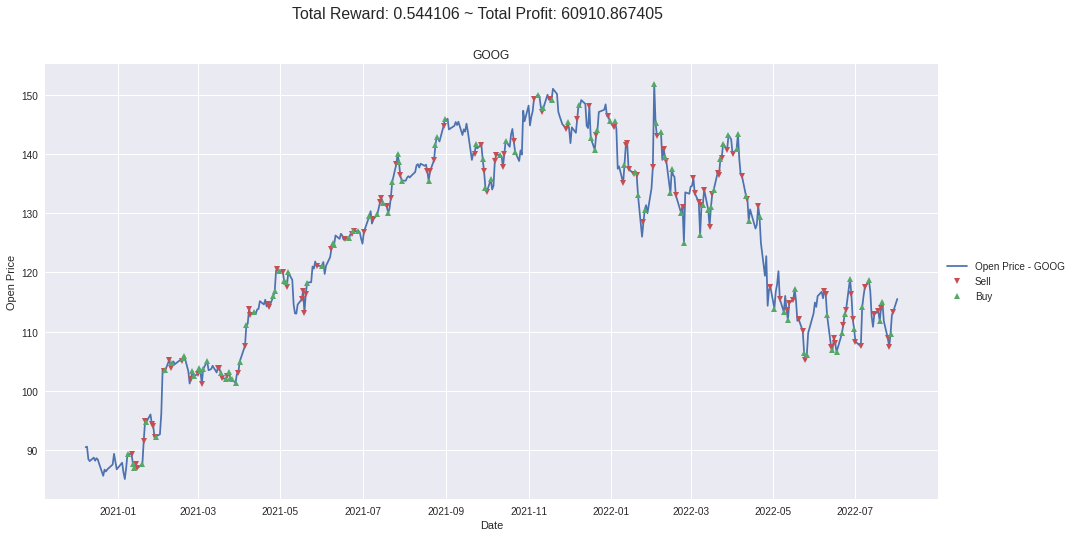

In [ ]:
plt.figure(figsize=(16, 8))
test_env.render_all()
plt.title("GOOG")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
observation = env.reset(False)

while True:

    action, _states = best_ppo_agent.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'date': '2020-12-07 00:00:00+00:00', 'total_reward': 6.84524, 'total_profit': 75225707.89003, 'total_profit_percentage': 752.25708, 'buy_and_hold': 2.2289, 'daily_price_return': -0.00303, 'daily_return': -0.00303, 'total_assets': 75325707.89003}


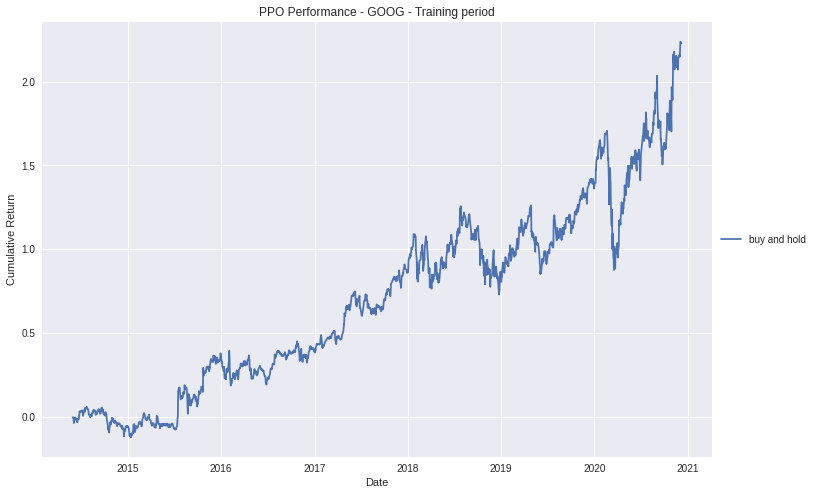

In [ ]:
plt.figure(figsize=(12,8))
x = pd.to_datetime(env.history['date'])
# plt.plot(x,np.array(test_env.history['buy_and_hold'])*test_env.init_cash)
plt.plot(x,env.history['buy_and_hold'],label="buy and hold")
# plt.plot(x,env.history['total_profit_percentage'],label="PPO")
plt.title("PPO Performance - GOOG - Training period")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

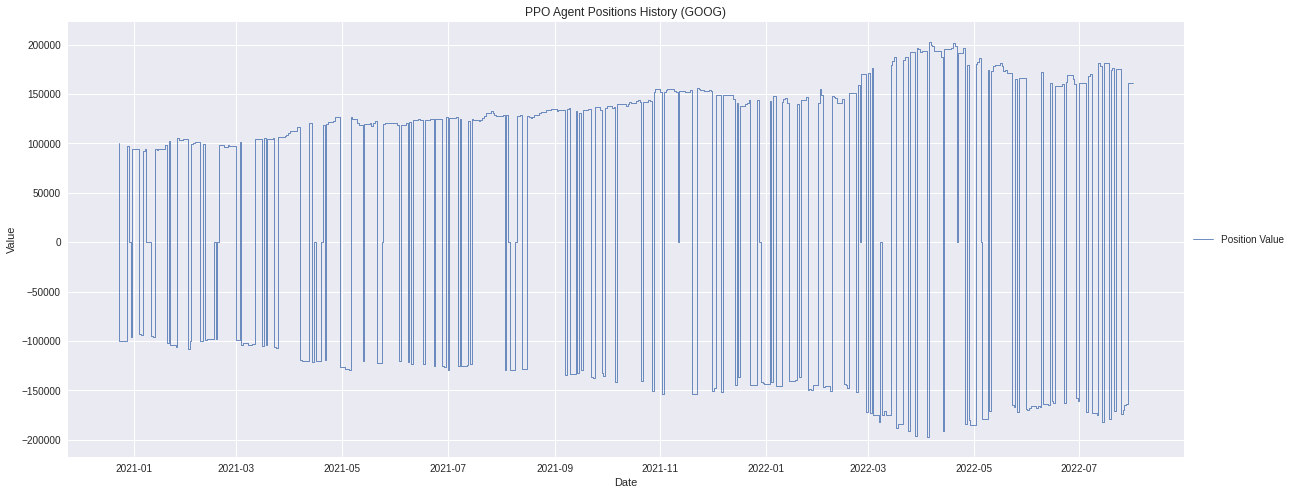

In [ ]:
plt.figure(figsize=(20,8))
plt.step(
    pd.to_datetime(test_env.history["date"]),
    test_env._position_history[11:],
    label="Position Value",
    linewidth=0.8
    )
plt.title("PPO Agent Positions History (GOOG)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

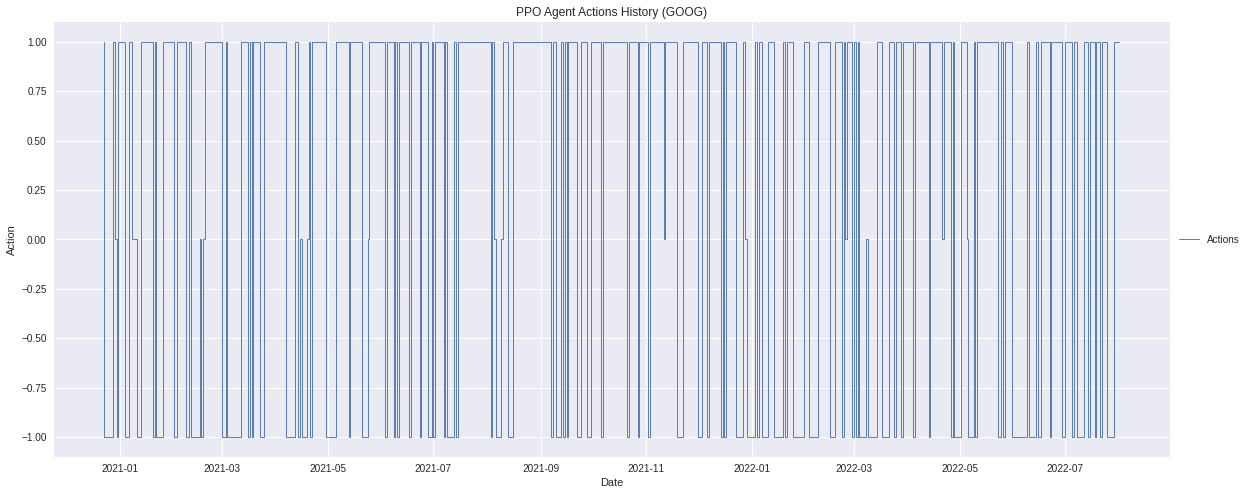

In [ ]:

plt.figure(figsize=(20,8))
plt.step(
    pd.to_datetime(test_env.history["date"]),
    test_env._actions_history[11:],
    label="Actions",
    linewidth=0.9
    )
plt.title("PPO Agent Actions History (GOOG)")
plt.xlabel("Date")
plt.ylabel("Action")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


Text(0.5, 0, 'Positions Value')

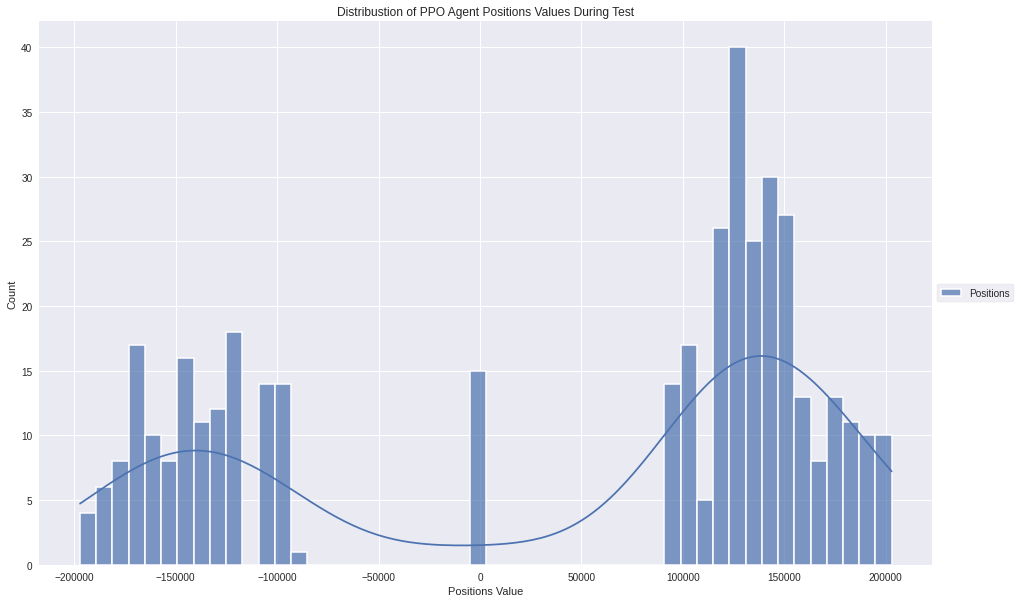

In [ ]:
plt.figure(figsize=(16,10))
ppo_positions = pd.DataFrame()
ppo_positions["Positions"] = test_env._position_history[11:]
ppo_positions.index = pd.to_datetime(test_env.history["date"])

ax = sns.histplot(
    data=ppo_positions,
    fill=True,
    common_norm=False,
    bins=50,
    alpha=.7, linewidth=1.5,kde=True
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Distribustion of PPO Agent Positions Values During Test")
plt.xlabel("Positions Value")

Text(0.5, 0, 'Positions Value')

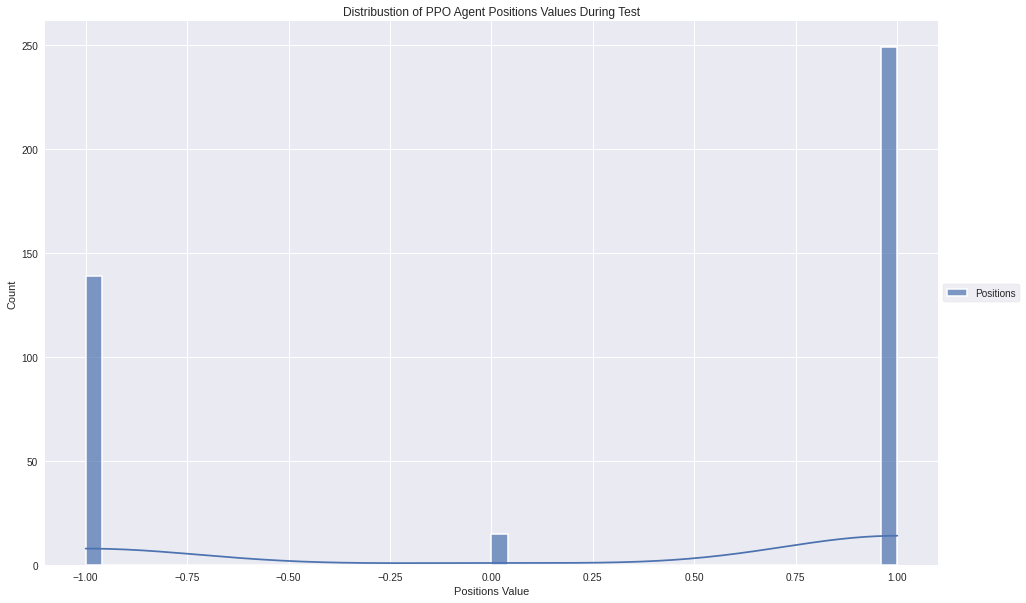

In [ ]:
plt.figure(figsize=(16,10))
ppo_actions = pd.DataFrame()
ppo_actions["Positions"] = test_env._actions_history[11:]
ppo_actions.index = pd.to_datetime(test_env.history["date"])

ax = sns.histplot(
    data=ppo_actions,
    fill=True,
    common_norm=False,
    bins=50,
    alpha=.7, linewidth=1.5,kde=True
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Distribustion of PPO Agent Positions Values During Test")
plt.xlabel("Positions Value")

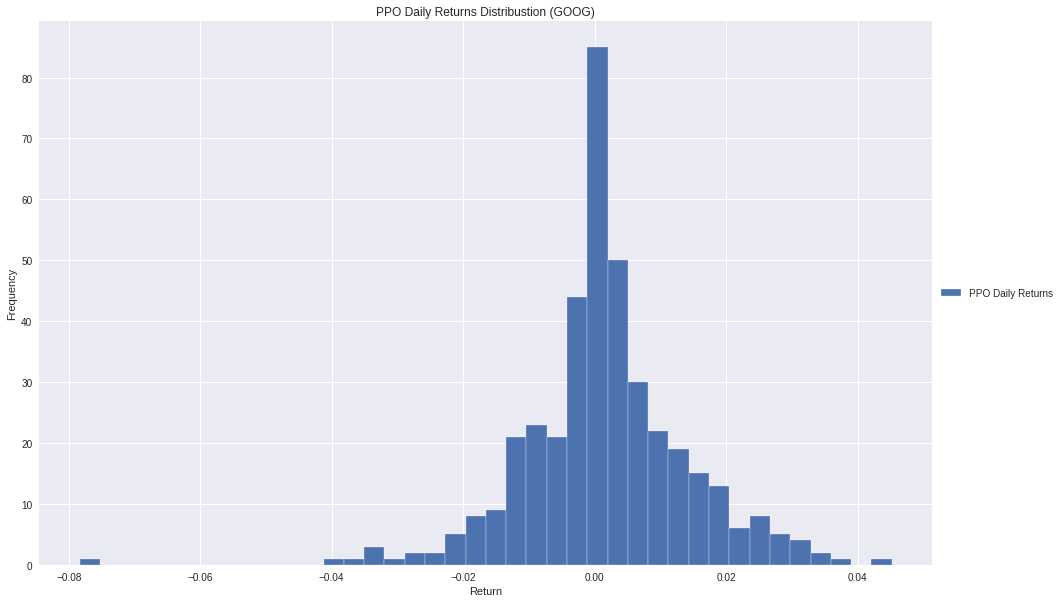

In [ ]:
plt.figure(figsize=(16,10))
plt.hist(
    ppo2_model_res["daily_return_point"],
    label="PPO Daily Returns",
    bins=40,
    # kde=True
    )
plt.title("PPO Daily Returns Distribustion (GOOG)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


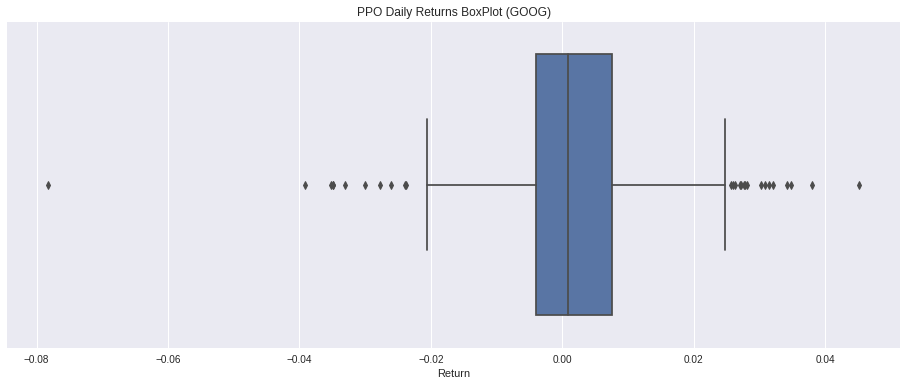

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(
    ppo_agent_res["daily_return_point"],
    # label="PPO Daily Returns",
    # bins=40,
    # kde=True
    )
plt.title("PPO Daily Returns BoxPlot (GOOG)")
plt.xlabel("Return")
# plt.ylabel("Frequency")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## DQN Agent

In [ ]:
dqn_env = MyTradingEnv(df=df_train, window_size=window_size, frame_bound=(window_size, len(df_train)),symbol="GOOG",IS_DQN=True)
dqn_test_env = MyTradingEnv(df=df_test, window_size=window_size, frame_bound=(window_size, len(df_test)),symbol="GOOG",IS_DQN=True)


In [ ]:
# dqn_model = DQN.load("D:\Python Projects\personal_projects\DeepRl trading v2\src\saved_agents\ddpg_20220820\dqn_aapl_v1.zip")

### Agent Setting

In [ ]:
dqn_agent = DQN("MlpPolicy", dqn_env, verbose=1,
        learning_rate=0.0001,
        buffer_size=1000000,
        learning_starts=50000,
        batch_size=512,
        tau=0.99,
        gamma=0.99,
        train_freq=(1000, "step"),
        gradient_steps=1,
        target_update_interval=5000,
        exploration_fraction=0.2,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.02
        )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
TRAIN_DQN = True
dqn_checkponit_dir = './dqn_goog_chekpoint'
dqn_log_dir = './dqn_goog_logs'
checkpoint_freq = 5000

if not os.path.isdir(dqn_checkponit_dir):
    os.mkdir(dqn_checkponit_dir)
if not os.path.isdir(dqn_log_dir):
    os.mkdir(dqn_log_dir)

In [ ]:
dqn_eval_callback = EvalCallback(dqn_test_env, best_model_save_path=dqn_checkponit_dir,
                                log_path=dqn_log_dir, eval_freq=5000,
                                deterministic=True, render=False)


### Training

In [ ]:
if TRAIN_DQN:
    dqn_agent.learn(total_timesteps=700000,callback=dqn_eval_callback)
    dqn_agent.save(agent_save_folder+"/DQN_GOOG_last_trained")
    best_dqn_agent = DQN.load(dqn_checkponit_dir+"/best_model.zip")
else:
    best_dqn_agent = DQN.load(dqn_checkponit_dir+"/best_model.zip")
    best_dqn_agent.set_env(dqn_env)

Eval num_timesteps=5000, episode_reward=-0.32 +/- 0.00
Episode length: 403.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 403      |
|    mean_reward      | -0.317   |
| rollout/            |          |
|    exploration_rate | 0.965    |
| time/               |          |
|    total_timesteps  | 5000     |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.64e+03 |
|    ep_rew_mean      | 0.475    |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1511     |
|    time_elapsed     | 4        |
|    total_timesteps  | 6576     |
----------------------------------
Eval num_timesteps=10000, episode_reward=-0.32 +/- 0.00
Episode length: 403.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 403      

### Results and Validation

In [ ]:
best_dqn_agent.set_random_seed(seed)
dqn_agent_res = test_model(best_dqn_agent, dqn_test_env ,500)
dqn_agent_res['perf_stat']

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py:724: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
100%|██████████| 500/500 [01:48<00:00,  4.60it/s]
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,point_est (mean),%95 conf. lower bound,%95 conf. upper bound,%99 conf. lower bound,%99 conf. upper bound,3sigma lower,3sigma upper,best_5_pctile,worst_5_pctile,best_20_pctile,best_20_pctile
Annual return,0.525238,0.520666,0.529809,0.519221,0.531254,0.447192,0.603283,0.606003,0.441180,0.563050,0.488013
Cumulative returns,0.965335,0.955963,0.974707,0.953001,0.977669,0.805341,1.125329,1.133198,0.794003,1.042690,0.888138
Annual volatility,0.218575,0.218389,0.218761,0.218330,0.218820,0.215396,0.221754,0.222429,0.215913,0.219498,0.217545
Sharpe ratio,2.039023,2.024947,2.053099,2.020497,2.057548,1.798717,2.279329,2.276942,1.766735,2.158573,1.930464
Calmar ratio,4.531073,4.472956,4.589191,4.454586,4.607560,3.538910,5.523237,5.544965,3.388088,4.945301,4.141896
Stability,0.895346,0.892257,0.898435,0.891280,0.899412,0.842606,0.948085,0.930576,0.847108,0.916062,0.881142
Max drawdown,-0.117017,-0.117870,-0.116165,-0.118139,-0.115895,-0.131571,-0.102463,-0.106341,-0.134635,-0.114648,-0.117513
Omega ratio,1.582230,1.577168,1.587292,1.575569,1.588892,1.495819,1.668641,1.665912,1.487261,1.624787,1.542587
Sortino ratio,3.316054,3.288687,3.343421,3.280038,3.352071,2.848860,3.783248,3.774583,2.791331,3.536847,3.111731
Skew,0.512512,0.501116,0.523907,0.497514,0.527509,0.317969,0.707054,0.616941,0.306725,0.548935,0.514452


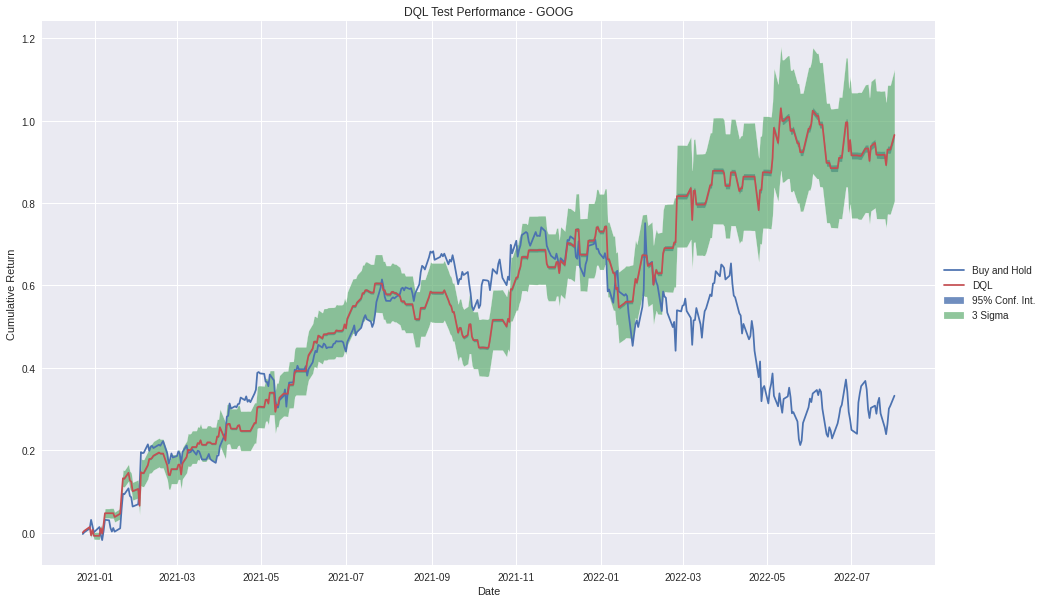

In [ ]:
plot_test_result(result_dict=dqn_agent_res, model_name="DQL", symbol="GOOG", split="Test")

In [ ]:
dqn_agent_res['perf_stat'].to_csv("DQN_GOOG_stats.csv")

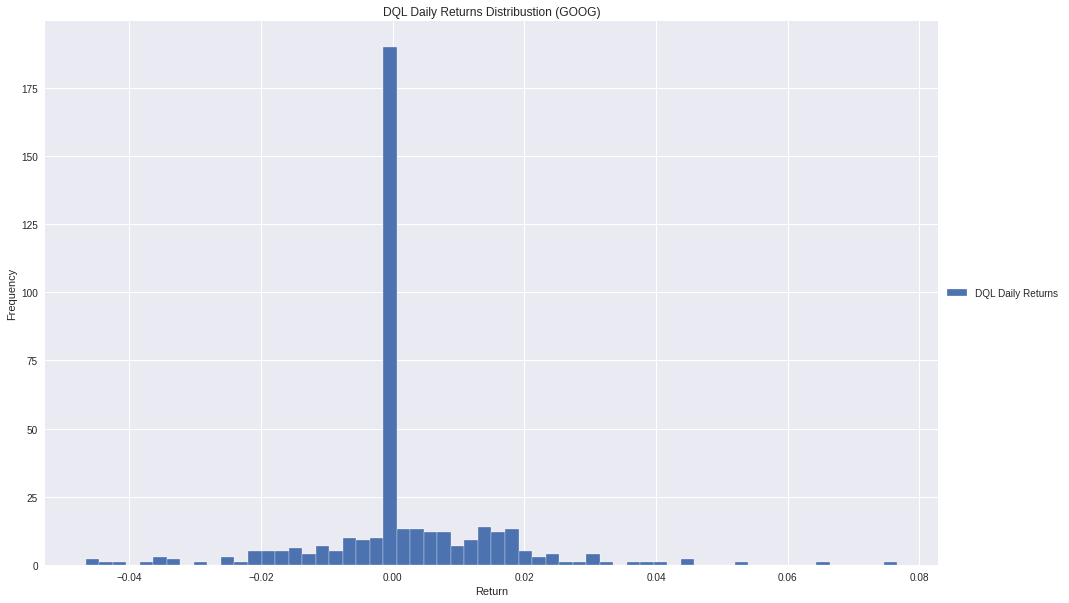

In [ ]:
plt.figure(figsize=(16,10))
plt.hist(
    dqn_agent_res["daily_return_point"],
    label="DQL Daily Returns",
    bins=60,
    )
plt.title("DQL Daily Returns Distribustion (GOOG)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:

observation = dqn_test_env.reset(False)

while True:

    action, _states = best_dqn_agent.predict(observation)
    observation, reward, done, info = dqn_test_env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'date': '2022-08-01 00:00:00+00:00', 'total_reward': 0.81591, 'total_profit': 117633.74945, 'total_profit_percentage': 1.17634, 'buy_and_hold': 0.3322, 'daily_price_return': 0.01878, 'daily_return': 0.01878, 'total_assets': 217633.74945}


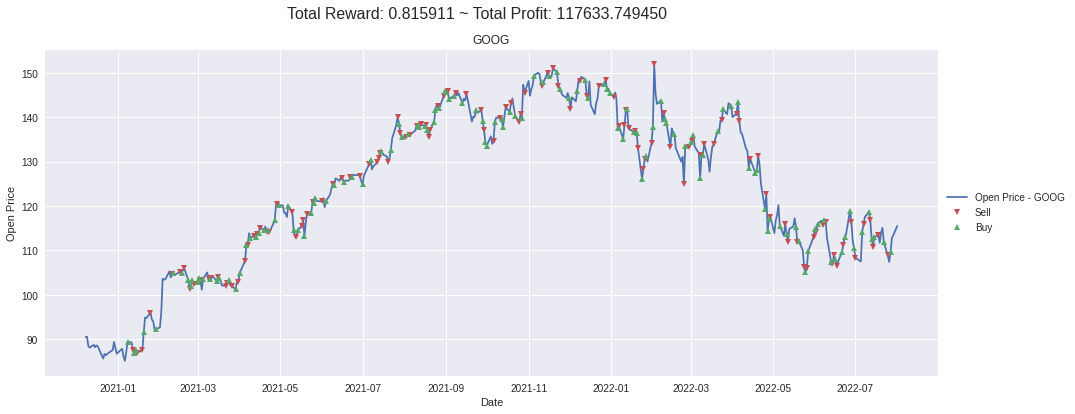

In [ ]:
plt.figure(figsize=(16, 6))
dqn_test_env.render_all()
plt.title("GOOG")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

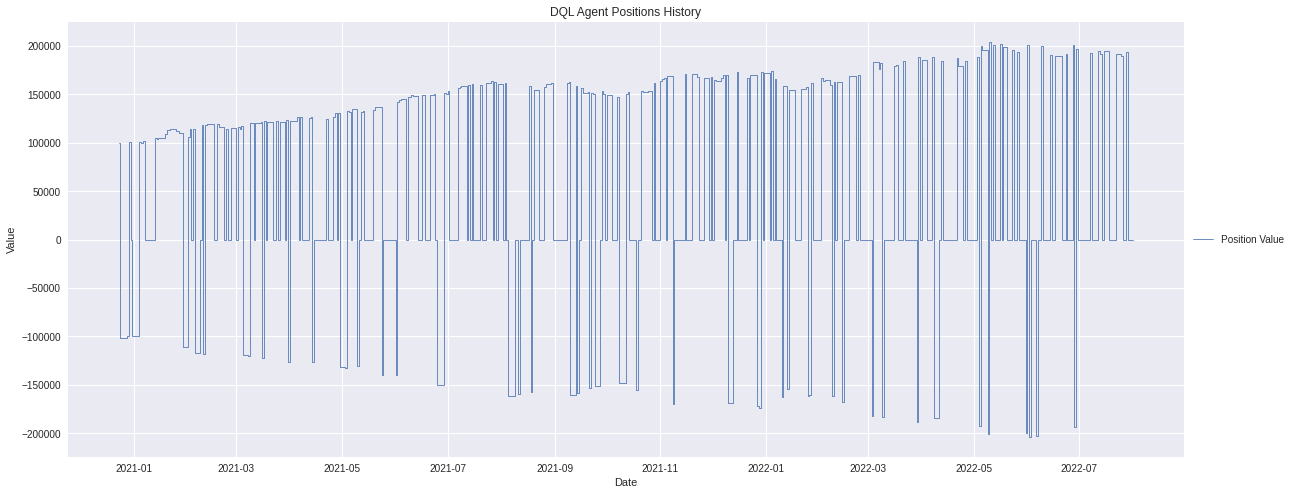

In [ ]:
plt.figure(figsize=(20,8))
plt.step(
    pd.to_datetime(dqn_test_env.history["date"]),
    dqn_test_env._position_history[11:],
    label="Position Value",
    linewidth=0.8
    )
plt.title("DQL Agent Positions History")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

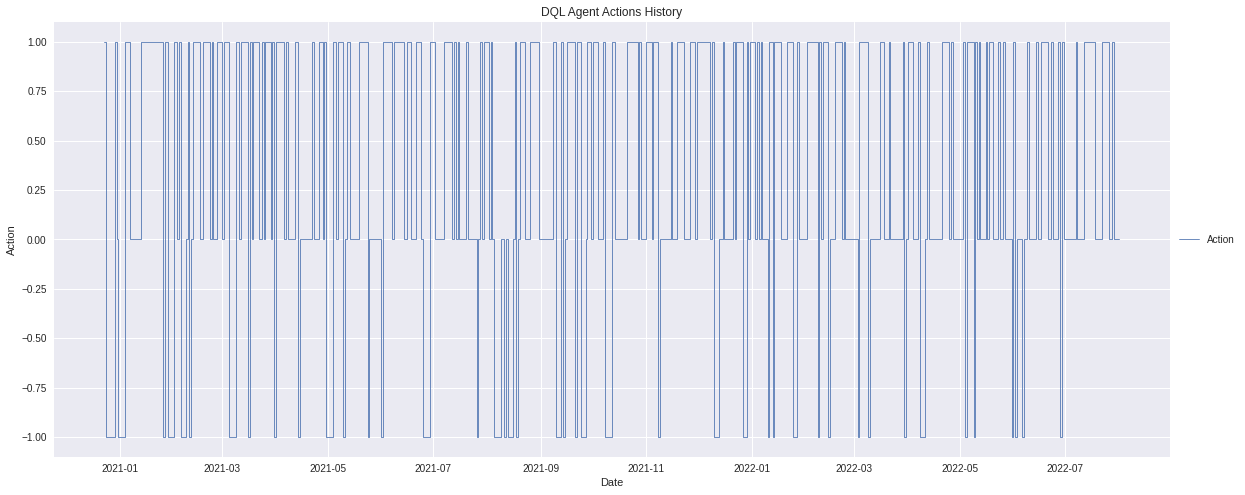

In [ ]:
plt.figure(figsize=(20,8))
plt.step(
    pd.to_datetime(dqn_test_env.history["date"]),
    dqn_test_env._actions_history[11:],
    label="Action",
    linewidth=0.8
    )
plt.title("DQL Agent Actions History")
plt.xlabel("Date")
plt.ylabel("Action")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Text(0.5, 0, 'Positions Value')

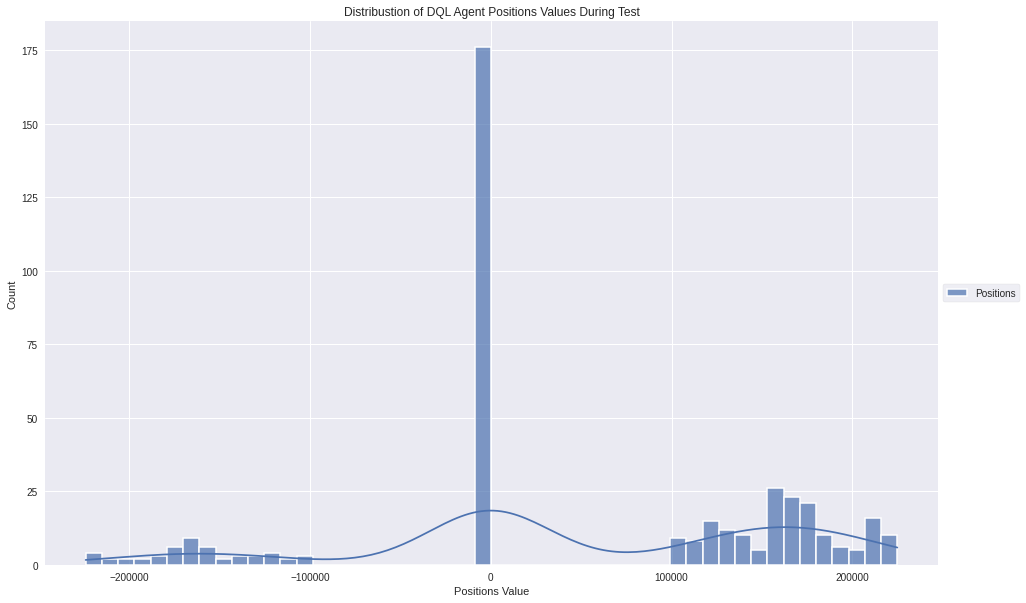

In [ ]:
plt.figure(figsize=(16,10))
actions = pd.DataFrame()
actions["Positions"] = dqn_test_env._position_history[11:]
actions.index = pd.to_datetime(dqn_test_env.history["date"])

ax = sns.histplot(
    data=actions,
    fill=True,
    common_norm=False,
    bins=50,
    alpha=.7, linewidth=1.5,kde=True
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Distribustion of DQL Agent Positions Values During Test")
plt.xlabel("Positions Value")
# plt.ylabel("Frequency");
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Text(0.5, 0, 'Actions')

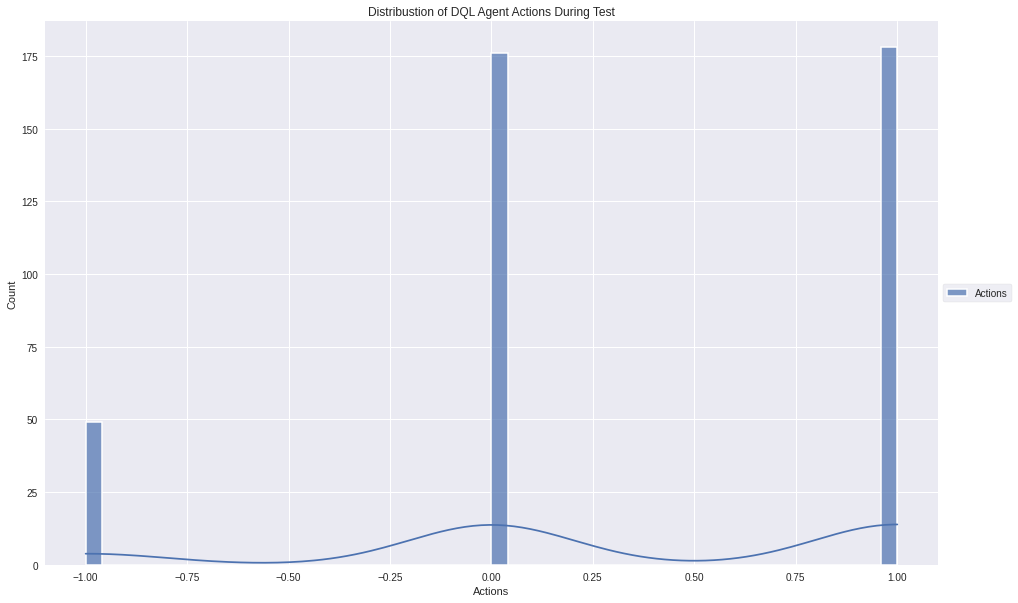

In [ ]:
plt.figure(figsize=(16,10))
actions = pd.DataFrame()
actions["Actions"] = dqn_test_env._actions_history[11:]
actions.index = pd.to_datetime(dqn_test_env.history["date"])

ax = sns.histplot(
    data=actions,
    fill=True,
    common_norm=False,
    bins=50,
    alpha=.7, linewidth=1.5,kde=True
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Distribustion of DQL Agent Actions During Test")
plt.xlabel("Actions")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


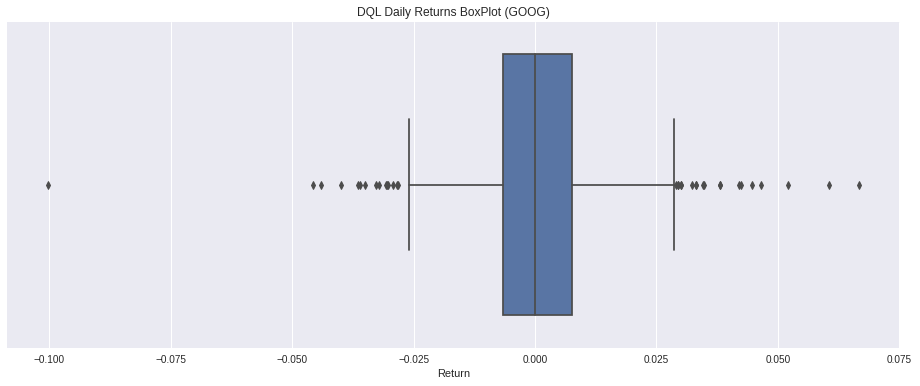

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(
    dqn2_res["daily_return_point"],
    # label="PPO Daily Returns",
    # bins=40,
    # kde=True
    )
plt.title("DQL Daily Returns BoxPlot (GOOG)")
plt.xlabel("Return")
# plt.ylabel("Frequency")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Visualization

In [ ]:
df_train.drop(columns=["volume_GOOG"]).corr().to_csv("feature_correlations.csv")

Text(0.5, 1.0, 'Features Correlation Matrix Heatmap')

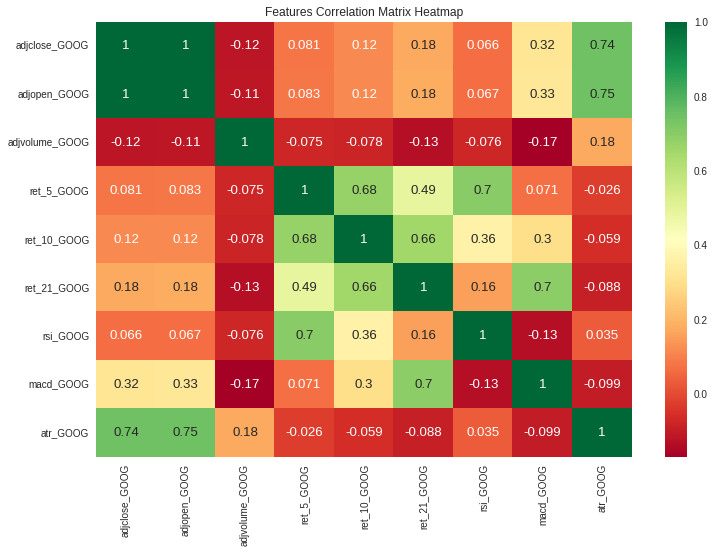

In [ ]:
plt.figure(figsize=(12,8))
labels = df_train.drop(columns=["volume_GOOG"]).corr().values
sns.heatmap(df_train.drop(columns=["volume_GOOG"]).corr(),annot=labels, cmap='RdYlGn')
plt.title("Features Correlation Matrix Heatmap")

In [ ]:
best_dqn_res.keys()

dict_keys(['date', 'total_reward_point', 'total_reward_lower95', 'total_reward_upper95', 'total_reward_lower99', 'total_reward_upper99', 'total_reward_min', 'total_reward_max', 'total_reward_lower3S', 'total_reward_upper3S', 'total_profit_point', 'total_profit_lower95', 'total_profit_upper95', 'total_profit_lower99', 'total_profit_upper99', 'total_profit_min', 'total_profit_max', 'total_profit_lower3S', 'total_profit_upper3S', 'total_profit_percentage_point', 'total_profit_percentage_lower95', 'total_profit_percentage_upper95', 'total_profit_percentage_lower99', 'total_profit_percentage_upper99', 'total_profit_percentage_min', 'total_profit_percentage_max', 'total_profit_percentage_lower3S', 'total_profit_percentage_upper3S', 'buy_and_hold', 'daily_price_return', 'daily_return_point', 'daily_return_lower95', 'daily_return_upper95', 'daily_return_lower99', 'daily_return_upper99', 'daily_return_min', 'daily_return_max', 'daily_return_lower3S', 'daily_return_upper3S', 'total_assets_point'

In [ ]:
daily_rets = pd.DataFrame()
daily_rets["PPO"] = ppo_agent_res["daily_return_point"]
daily_rets["DQL"] = dqn_agent_res["daily_return_point"]
daily_rets["Buy&Hold"] = dqn_agent_res["daily_price_return"]

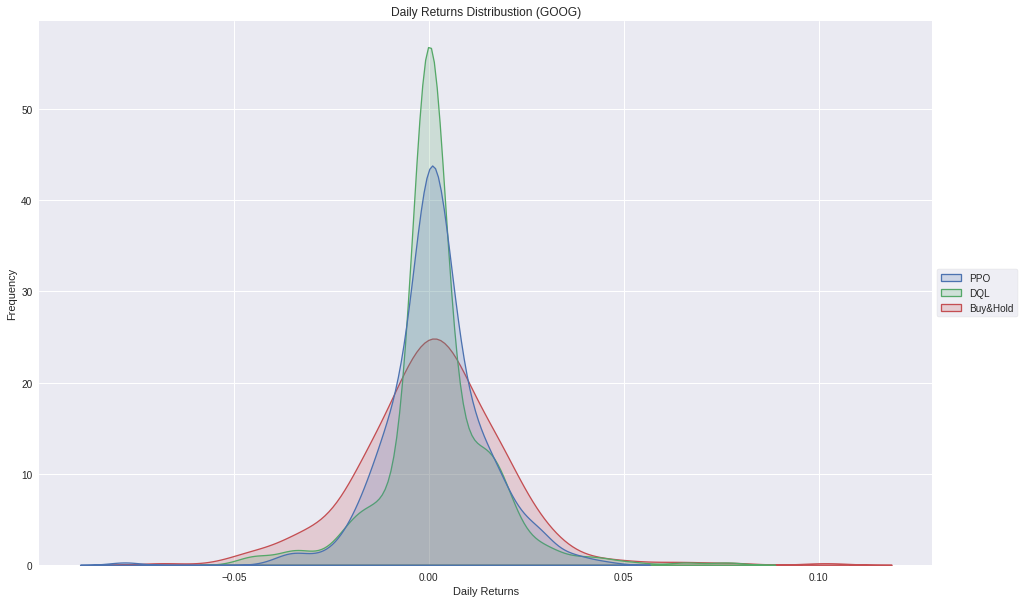

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.kdeplot(
   data=daily_rets,
   fill=True,
   common_norm=False,
#    palette="crest",
   alpha=.2, linewidth=1.3,
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily Returns Distribustion (GOOG)")
plt.xlabel("Daily Returns")
plt.ylabel("Frequency");
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

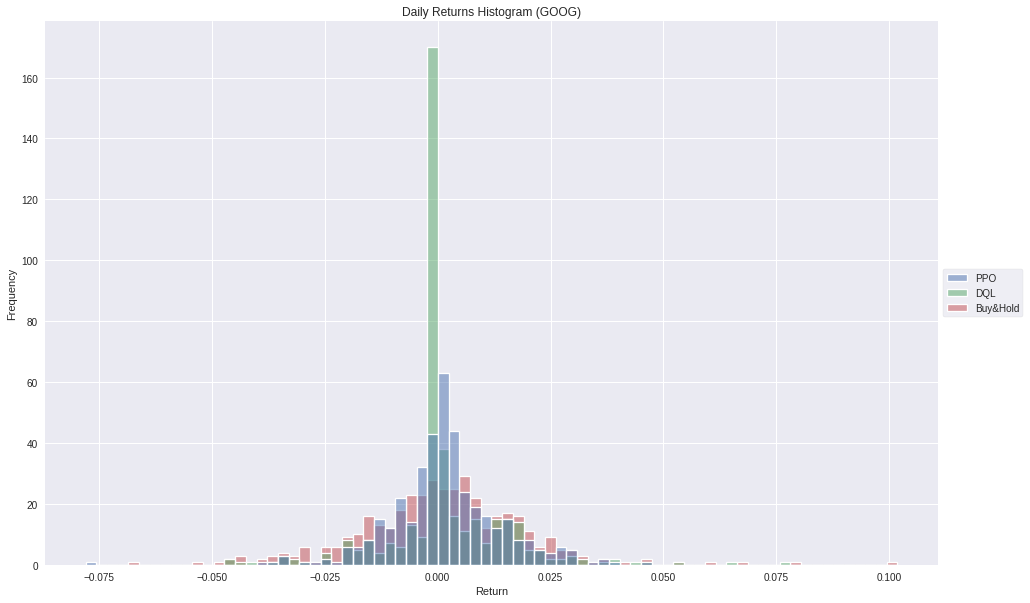

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.histplot(
   data=daily_rets,
   fill=True,
#    common_norm=False,
#    palette="crest",
   alpha=.5, linewidth=1.3,
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily Returns Histogram (GOOG)")
plt.xlabel("Return")
plt.ylabel("Frequency");

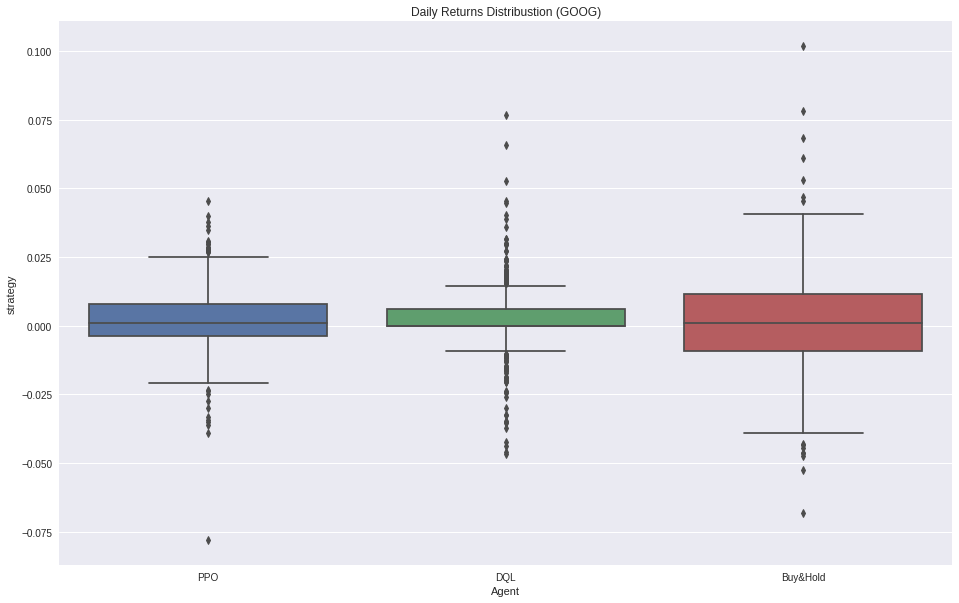

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.boxplot(
   data=daily_rets,
#    split=True
#    fill=True,
#    common_norm=False,
#    palette="crest",
#    alpha=.2, linewidth=1.3,
#    legend=True
)
# sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily Returns Distribustion (GOOG)")
plt.xlabel("Agent")
plt.ylabel("strategy");

In [ ]:
# ppo_res
best_dqn_res.keys()

dict_keys(['date', 'total_reward_point', 'total_reward_lower95', 'total_reward_upper95', 'total_reward_lower99', 'total_reward_upper99', 'total_reward_min', 'total_reward_max', 'total_reward_lower3S', 'total_reward_upper3S', 'total_profit_point', 'total_profit_lower95', 'total_profit_upper95', 'total_profit_lower99', 'total_profit_upper99', 'total_profit_min', 'total_profit_max', 'total_profit_lower3S', 'total_profit_upper3S', 'total_profit_percentage_point', 'total_profit_percentage_lower95', 'total_profit_percentage_upper95', 'total_profit_percentage_lower99', 'total_profit_percentage_upper99', 'total_profit_percentage_min', 'total_profit_percentage_max', 'total_profit_percentage_lower3S', 'total_profit_percentage_upper3S', 'buy_and_hold', 'daily_price_return', 'daily_return_point', 'daily_return_lower95', 'daily_return_upper95', 'daily_return_lower99', 'daily_return_upper99', 'daily_return_min', 'daily_return_max', 'daily_return_lower3S', 'daily_return_upper3S', 'total_assets_point'

In [ ]:
test_perfs = pd.DataFrame()
test_perfs["PPO"] = ppo_agent_res["total_profit_percentage_point"]
test_perfs["DQL"] = dqn_agent_res["total_profit_percentage_point"]
test_perfs["Buy&Hold"] = dqn_agent_res["buy_and_hold"]
test_perfs.index = pd.to_datetime(dqn_agent_res['date'])

worst_case = pd.DataFrame()
worst_case["PPO 5th percentile"] = ppo_agent_res["total_profit_percentage_worst5pctile"]
worst_case["DQL 5th percentile"] = dqn_agent_res["total_profit_percentage_worst5pctile"]
worst_case.index = pd.to_datetime(dqn_agent_res['date'])

Text(0, 0.5, 'Cumulative Return')

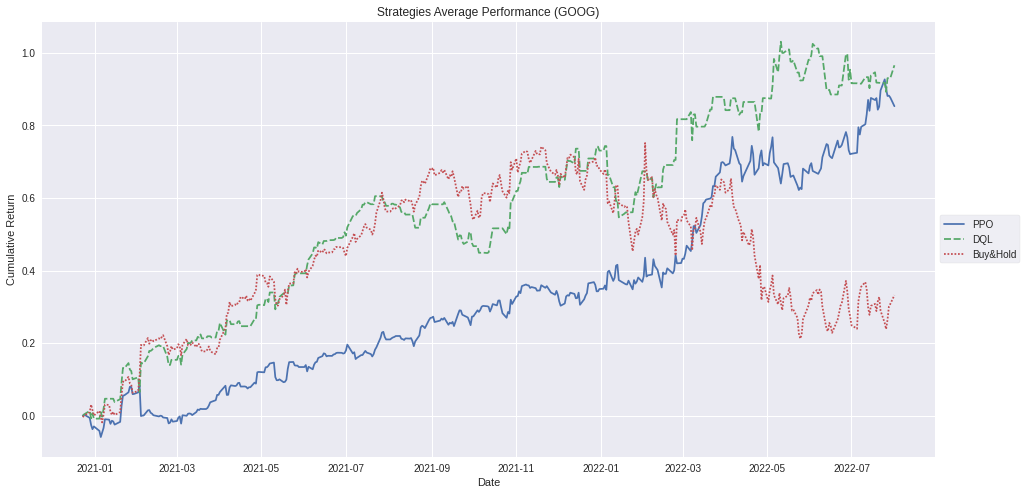

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(
   data=test_perfs,
#    fill=True,
#    common_norm=False,
#    palette="crest",
#    alpha=.9,
#    linewidth=1.8,
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Strategies Average Performance (GOOG)")
plt.xlabel("Date");
plt.ylabel("Cumulative Return")

Text(0, 0.5, 'Cumulative Return')

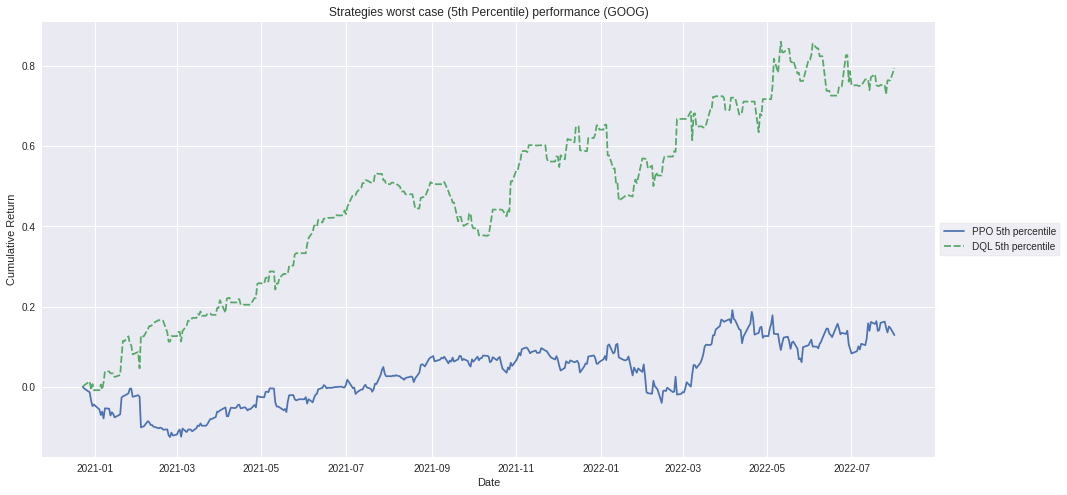

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(
   data=worst_case,
#    fill=True,
#    common_norm=False,
#    palette="crest",
#    alpha=.9,
#    linewidth=1.8,
#    legend=True
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Strategies worst case (5th Percentile) performance (GOOG)")
plt.xlabel("Date");
plt.ylabel("Cumulative Return")

In [ ]:

worst_cas20 = pd.DataFrame()
worst_cas20["PPO 20th percentile"] = ppo_agent_res["total_profit_percentage_worst20"]
worst_cas20["DQL 20th percentile"] = dqn_agent_res["total_profit_percentage_worst20"]
worst_cas20.index = pd.to_datetime(dqn_agent_res['date'])

Text(0, 0.5, 'Cumulative Return')

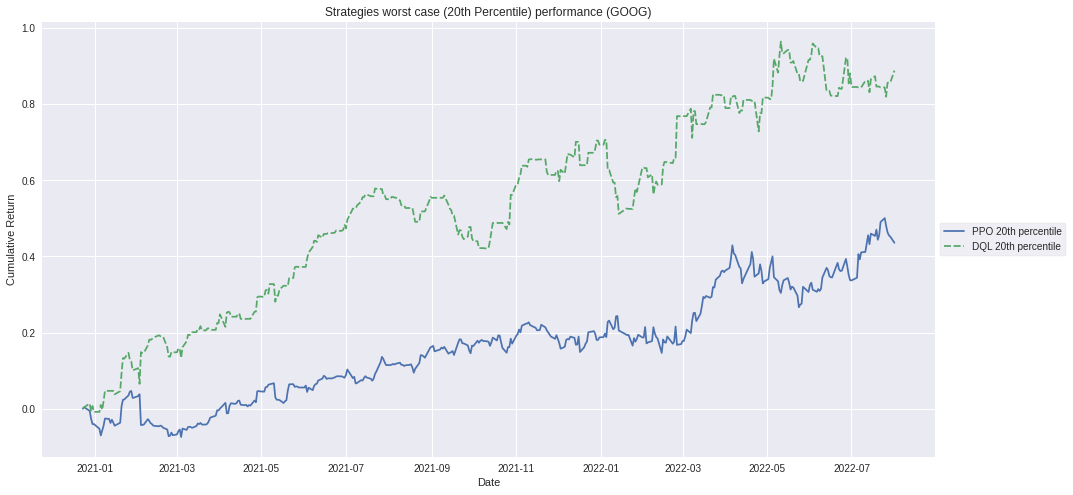

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(
   data=worst_cas20
)
sns.move_legend(ax,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Strategies worst case (20th Percentile) performance (GOOG)")
plt.xlabel("Date");
plt.ylabel("Cumulative Return")